**BUSGLite**
- Breast Ultrasound Generator Lite
- 乳腺肿物超声图像生成器轻量版

**面向临床教学的轻量级乳腺肿物超声图像生成模型构建及其在乳房疾病虚拟病例中的应用**

**摘要**
**目的** 构建轻量级、低成本、易部署的乳腺肿物超声图像生成模型，为临床医学本科生乳房疾病虚拟病例教学提供影像学支持。
**方法** 以Stable Diffusion模型为基础，数据集为Kaggle网站上提供的公开乳腺超声图片集 Breast Ultrasound Images Dataset，采用LoRA技术进行图像微调，在常规低配置平台上实现基于语义提示下的乳腺肿物良恶性超声图片的生成。将生成图片和数据集图片随机分配给5名乳腺外科临床医师和30名规培轮转学生。将30名学生分为两组，对照组仅提供30张实际图片，实验组提供同样30张图片后，附加30张生成图片。之后对照组及实验组对同样一组20张实际超声图片/10张生成图片进行评估。同时提供乳房疾病虚拟病例，记录医师和学生对图片的良恶性分辨及是否为生成图片，分析模型的生成效果及是否满足临床教学需要。
**结果** 构建的模型大小为100MB，生成单张512*512像素图片耗时5秒（RTX 4070Ti），显存占用2GB。临床医师分析图片肿物良恶性分类正确率为95%，学生对照组为 65%/80%，实验组为70%/90%，具有统计学差异；临床医师盲评是否生成图片正确率为60%，学生对照组为50%/55%，实验组为55%/55%，统计学无差异性。
**结论** 轻量级乳腺肿物生成模型可以应用于临床医学教学中，可以提升教师的教学效率，并帮助学生的快速掌握临床技能。

**关键词** 乳腺肿瘤 超声 大模型 虚拟病例 临床教学

In [1]:
# 测试是否成功安装，True 则表示安装成功
import torch
torch.cuda.is_available()

True

In [2]:
# 设定模型缓存目录
import os
os.environ["MODELSCOPE_CACHE"] = "./modelscope_cache"

In [3]:
# 下载模型到缓存目录
from modelscope import snapshot_download
model_dir = snapshot_download("AI-ModelScope/stable-diffusion-v1-5")

In [ ]:
# 下载LORA
lora_dir = snapshot_download("sd_lora/LeLo-LEGO-LoRA-for-XL-SD1.5")

2026-01-18 14:19:30,179 - modelscope - INFO - Creating symbolic link [./modelscope_cache\models\sd_lora\LeLo-LEGO-LoRA-for-XL-SD1.5].
2026-01-18 14:19:30,180 - modelscope - WARNING - Failed to create symbolic link ./modelscope_cache\models\sd_lora\LeLo-LEGO-LoRA-for-XL-SD1.5 for d:\Projects\GitHub\Repositories\busglite\modelscope_cache\models\sd_lora\LeLo-LEGO-LoRA-for-XL-SD1___5.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPFeatureExtractor appears to have been deprecated in transformers. Using CLIPImageProcessor instead.


  0%|          | 0/50 [00:00<?, ?it/s]

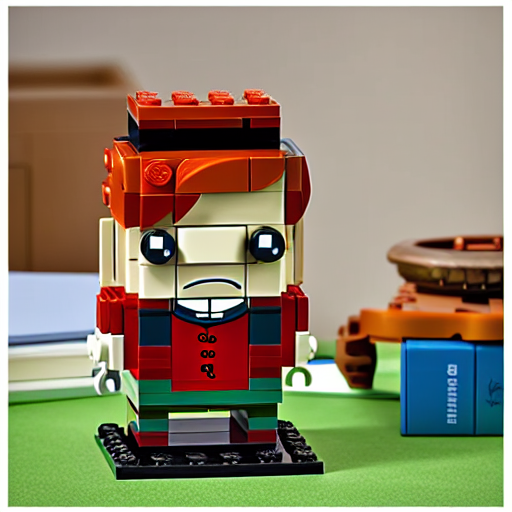

In [ ]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

# 核心，加载模型
pipeline = DiffusionPipeline.from_pretrained(model_dir, use_safetensors=True, local_files_only=True, torch_dtype=torch.float16).to("cuda")

# 加速
pipeline.enable_model_cpu_offload()

# torch.compile 目前用于 Python 3.13.3+ , 不支持 3.14
# pipeline.unet = torch.compile(pipeline.unet, mode="max-autotune")

# 加速
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

# 加载 Lora
pipeline.load_lora_weights(
    lora_dir,
    weight_name="V1.1_SD1.5/lego_v1.1.safetensors",
)

# 负向提示词
negative_prompt = "low quality, blurry, ugly, poor details"

# 模型推理
pipeline("LEGO BrickHeadz, professor, ultra high quality, red head", negative_prompt=negative_prompt, num_inference_steps=50).images[0]
